# Simple example of encoding/decoding + visualization
In the notebook below we demonstrate how to seamlessly perform fractal encoding, decoding + show fractal blocks visualization with an end-to-end workflow:
1. Load an input image from a local path you provide.
2. Encode it using **fastfractal**.
3. Generate a **range-block visualization** (grid/quadtree partition overlay).
4. Decode the code back into an image.

The only required edit is setting `IMAGE_PATH` (by default path to grayscale lena) in the first code cell.

In [1]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from fastfractal.utils.visualize import visualize_blocks_from_file

IMAGE_PATH = Path(r"../tests/test-data/lena-gray.png")

OUT_DIR = Path("demo_out")
OUT_DIR.mkdir(parents=True, exist_ok=True)

ENCODED_PATH = OUT_DIR / "encoded.ffc"
BLOCKS_PATH = OUT_DIR / "blocks.png"
DECODED_PATH = OUT_DIR / "decoded.png"

assert IMAGE_PATH.exists(), f"Image not found: {IMAGE_PATH}"

PRESET = "quality"  # "speed" | "quality"

if PRESET == "speed":
    ENCODE_KWARGS = dict(
        max_block=16,
        min_block=8,
        use_quadtree=False,
        quantized=True,
        stride=4,
        topk=8,
        entropy_thresh=0.0,
        max_domains=128,
    )

elif PRESET == "quality":
    ENCODE_KWARGS = dict(
    max_block=16,
    min_block=2,
    use_quadtree=True,
    max_mse=0.0025,
    stride=2,
    topk=32,
    quantized=True,
    entropy_thresh=0.0,
    max_domains=512,
    transform_ids = "all",
    seed=0,
)
else:
    raise ValueError("PRESET must be 'speed' or 'quality'")

DECODE_ITERATIONS = 16

## Show original
Let's have an insight into the original image.

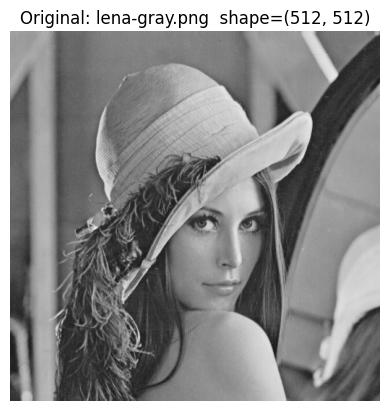

In [2]:
im0 = Image.open(IMAGE_PATH).convert("L")
arr0 = np.asarray(im0, dtype=np.uint8)

plt.figure()
plt.title(f"Original: {IMAGE_PATH.name}  shape={arr0.shape}")
plt.axis("off")
plt.imshow(arr0, cmap="gray", vmin=0, vmax=255)
plt.show()

## Encode (paths-only)

Below we encode the image into its fractal compression format.


In [3]:
from fastfractal.core.encode import encode_to_file

encode_to_file(IMAGE_PATH, ENCODED_PATH, **ENCODE_KWARGS)

orig_bytes = int(arr0.size)
ffc_bytes = int(ENCODED_PATH.stat().st_size)
cr = float(orig_bytes) / float(max(1, ffc_bytes))

print(f"Saved: {ENCODED_PATH}")
print(f"Raw bytes (uint8): {orig_bytes}")
print(f"FFC bytes: {ffc_bytes}")
print(f"Compression ratio (raw/ffc): {cr:.3f}x")

Saved: demo_out\encoded.ffc
Raw bytes (uint8): 262144
FFC bytes: 58180
Compression ratio (raw/ffc): 4.506x


## Visualize range blocks / quadtree partition

Produces an image similar to the block-structure overlay you shared.

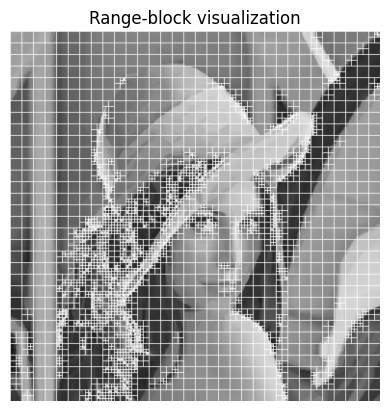

Saved: demo_out\blocks.png


In [4]:
visualize_blocks_from_file(
    ENCODED_PATH,
    BLOCKS_PATH,
    background="decode",
    grayscale=True,
    iterations=DECODE_ITERATIONS,
    thickness=1,
    alpha=1.0,
    upscale=2,
)

im_blocks = Image.open(BLOCKS_PATH).convert("L")
plt.figure()
plt.title("Range-block visualization")
plt.axis("off")
plt.imshow(im_blocks, cmap="gray", vmin=0, vmax=255)
plt.show()

print(f"Saved: {BLOCKS_PATH}")

## Decode

Decoding the compressed image (lossy compression).

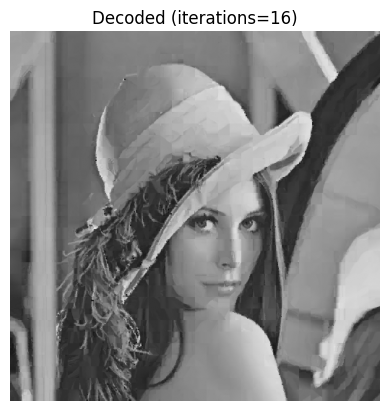

Saved: demo_out\decoded.png


In [5]:
from fastfractal.core.decode import decode_to_file

decode_to_file(ENCODED_PATH, DECODED_PATH, iterations=DECODE_ITERATIONS)

im_dec = Image.open(DECODED_PATH)
plt.figure()
plt.title(f"Decoded (iterations={DECODE_ITERATIONS})")
plt.axis("off")
plt.imshow(im_dec, cmap="gray", vmin=0, vmax=255)
plt.show()

print(f"Saved: {DECODED_PATH}")

## Comparison all together
Let's present a comparative showcase of conversion of few images next to each other (because we are making 6 high quality transformations, the cell might take some time to execute).  
Below the images the Compression Rate (CR) is shown, as well as the encoding time (in seconds). Since decoding time is negligible in any case, it is now presented.

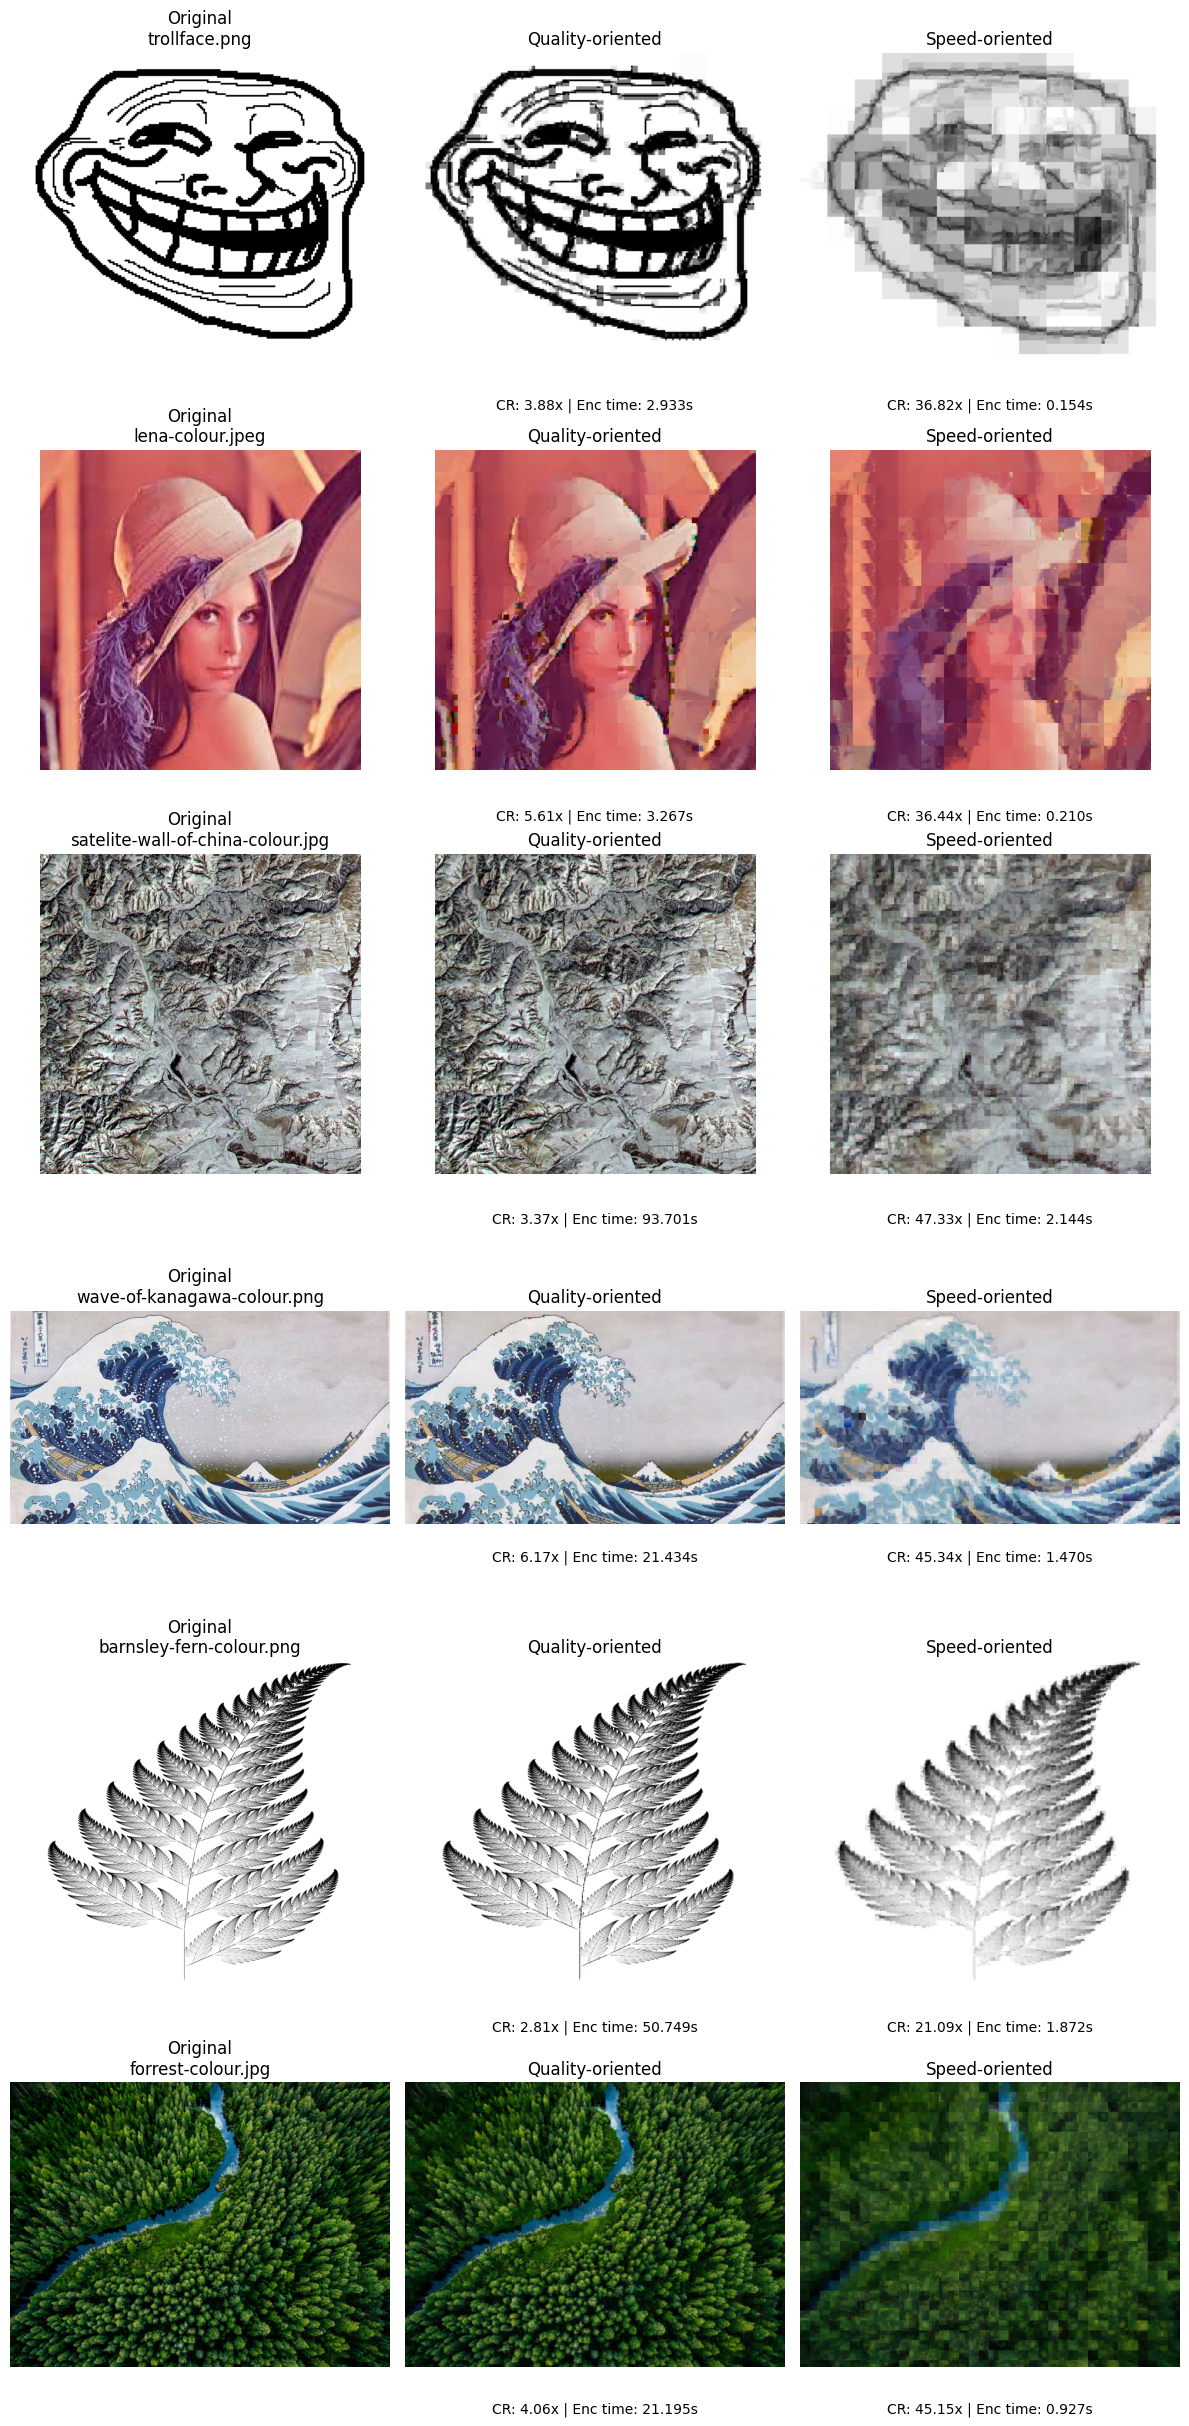

In [16]:
import random
import time
from pathlib import Path

import matplotlib.pyplot as plt

from fastfractal.core.encode import encode_array
from fastfractal.core.decode import decode_array
from fastfractal.io.imageio import load_image
from fastfractal.io.codebook import dump_code

TEST_DIR = Path("../tests/test-data/")
N_IMAGES = 6
RANDOM_SEED = 0
DECODE_ITERATIONS = 16

QUALITY_CFG = dict(
    max_block=16,
    min_block=4,
    use_quadtree=True,
    max_mse=0.0025,
    stride=2,
    topk=16,
    quantized=True,
    entropy_thresh=0.0,
    max_domains=512,
    transform_ids="all",
    seed=0,
)

SPEED_CFG = dict(
    max_block=16,
    min_block=8,
    use_quadtree=False,
    quantized=True,
    stride=4,
    topk=8,
    entropy_thresh=0.0,
    max_domains=128,
)

random.seed(RANDOM_SEED)
image_files = sorted(TEST_DIR.glob("*.*"))
image_files = random.sample(image_files, N_IMAGES)

fig, axes = plt.subplots(
    nrows=N_IMAGES,
    ncols=3,
    figsize=(12, 4 * N_IMAGES),
    squeeze=False,
)

for row, img_path in enumerate(image_files):
    original = load_image(img_path)
    orig_bytes = int(original.size)

    t0 = time.perf_counter()
    code_q = encode_array(original, **QUALITY_CFG)
    t_enc_q = time.perf_counter() - t0
    recon_q = decode_array(code_q, iterations=DECODE_ITERATIONS)
    q_bytes = len(dump_code(code_q))
    cr_q = float(orig_bytes) / float(max(1, q_bytes))

    t0 = time.perf_counter()
    code_s = encode_array(original, **SPEED_CFG)
    t_enc_s = time.perf_counter() - t0
    recon_s = decode_array(code_s, iterations=DECODE_ITERATIONS)
    s_bytes = len(dump_code(code_s))
    cr_s = float(orig_bytes) / float(max(1, s_bytes))

    axes[row, 0].imshow(original, cmap="gray")
    axes[row, 0].set_title(f"Original\n{img_path.name}")
    axes[row, 0].axis("off")

    axes[row, 1].imshow(recon_q, cmap="gray")
    axes[row, 1].set_title("Quality-oriented")
    axes[row, 1].axis("off")
    axes[row, 1].text(
        0.5,
        -0.12,
        f"CR: {cr_q:.2f}x | Enc time: {t_enc_q:.3f}s",
        ha="center",
        va="top",
        transform=axes[row, 1].transAxes,
        fontsize=10,
    )

    axes[row, 2].imshow(recon_s, cmap="gray")
    axes[row, 2].set_title("Speed-oriented")
    axes[row, 2].axis("off")
    axes[row, 2].text(
        0.5,
        -0.12,
        f"CR: {cr_s:.2f}x | Enc time: {t_enc_s:.3f}s",
        ha="center",
        va="top",
        transform=axes[row, 2].transAxes,
        fontsize=10,
    )

plt.tight_layout()
plt.show()
